# Cineman Streamlit Project

## Load Dependencies

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options as FirefoxOptions
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
from datetime import date
import re
import json

In [2]:
def is_time_format(input):
    try:
        time.strptime(input, '%H:%M')
        return True
    except ValueError:
        return False

## Scraping Cineman Data

### Loading and Saving Page Contents

In [3]:
def scrape_cineman(cities=["Zürich"]):
    """
    This function open a Selenium driver, goes to the cineman.ch Showtimes page.
    Then it scrapes the entries for a specified city.
    
    Optional argument:
    - cities: list of strings, specifies the cities for which showtimes will be scraped, defaults to ['Zürich']
    
    Returns:
    - content: html code of the page scraped with BeautifulSoup
    """
    # Open the driver and go to the page with the showtimes
    options = FirefoxOptions()
    options.add_argument("--headless")
    driver = webdriver.Firefox(options=options)
    driver.get("https://www.cineman.ch/en/showtimes/city/")
    time.sleep(15)   # have to wait for the advertisement to end

    # Click the cookie button
    cookie_button = driver.find_element_by_class_name("cc-btn")
    cookie_button.click()
    time.sleep(2)

    # Sort the showtimes by time
    sorting_buttons = driver.find_elements_by_class_name("text-overflow-hidden")
    sorting_buttons[2].click()

    # Click the region dropdown, select the city and save
    region_dropdown = driver.find_element_by_class_name("selectize-control")
    region_dropdown.click()

    input_div = driver.find_elements_by_xpath('//input[@type="text"]')
    for city in cities:
        input_div[6].send_keys(city)
        input_div[6].send_keys(Keys.RETURN)

    save_button = driver.find_element_by_class_name("select-region-save")
    save_button.click()

    # Scrape the content and close the driver
    content = BeautifulSoup(driver.page_source, features="html.parser")
    driver.close()
    
    return content

<html class="js no-touchevents" lang="en" style=""><!--<![endif]--><head><script async="" src="https://www.google-analytics.com/analytics.js" type="text/javascript"></script><script async="" src="https://s0.2mdn.net/instream/video/client.js" type="text/javascript"></script><script async="" src="//acdn.adnxs.com/ast/ast.js" type="text/javascript"></script><script async="" src="https://web-misc.ubimet.com/weatherapi/?jsonp=hr&amp;token=mSvlrOJzu6iZGLE6x1TMRkW5dU7CBaEOTaZkOIAjoIiV4M2RnwDf6AB94imgjQUd&amp;set=pollen,curr_temp,curr_situation,7d_1d_situation,7d_1d_temperature" type="text/javascript"></script><script async="" src="https://gbucket.ch/scripts/totm/v1/totmGBucket.js" type="text/javascript"></script><script async="" charset="utf-8" src="//imasdk.googleapis.com/js/sdkloader/ima3.js" type="text/javascript"></script><script async="" charset="utf-8" src="//ssl.p.jwpcdn.com/player/v/8.20.4/jwpsrv.js" type="text/javascript"></script><script async="" charset="utf-8" src="//ssl.p.jwpcdn.
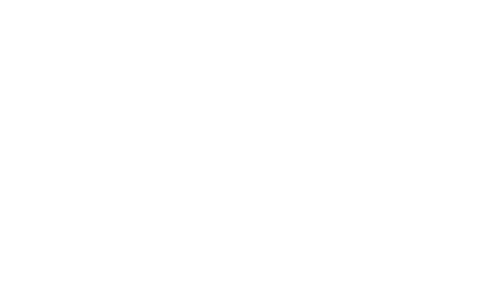
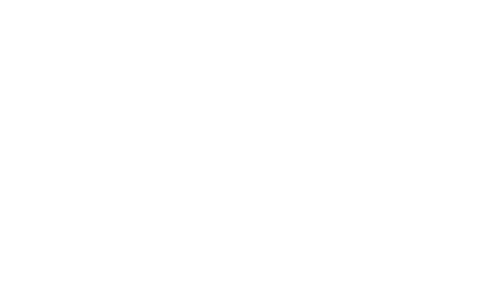
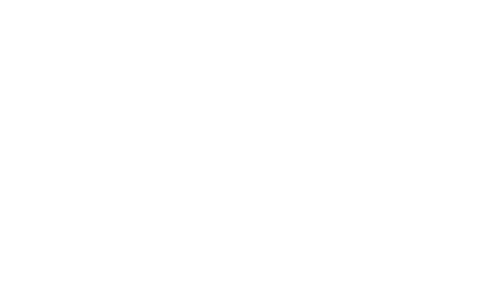
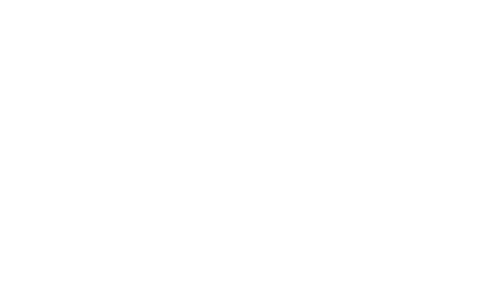
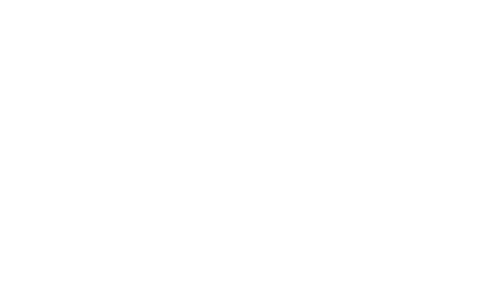
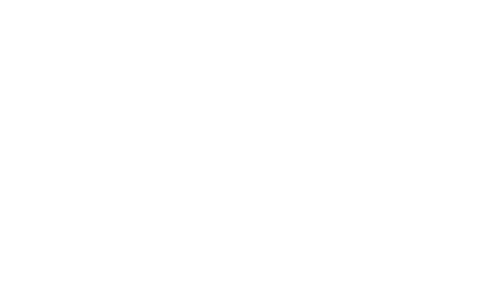
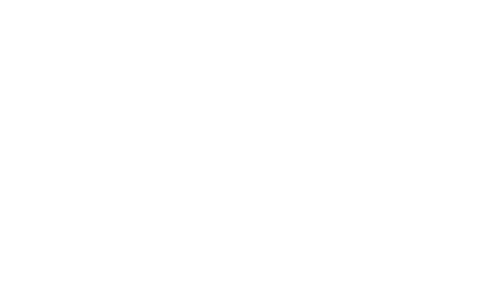
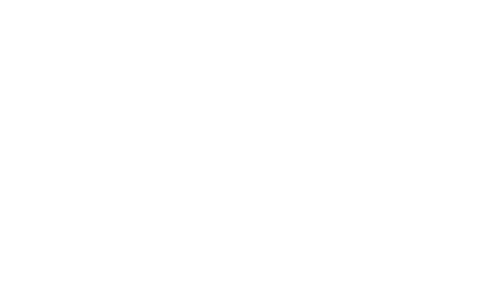
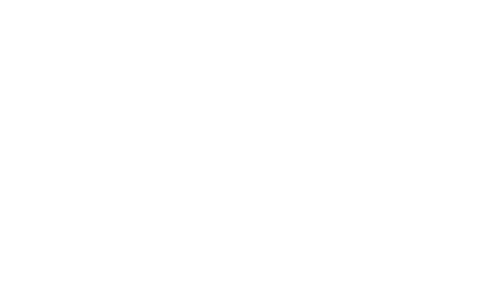
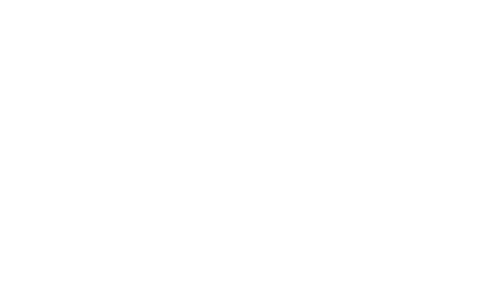
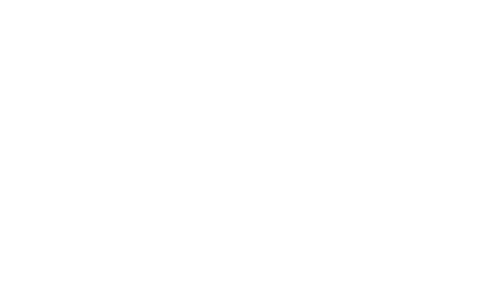
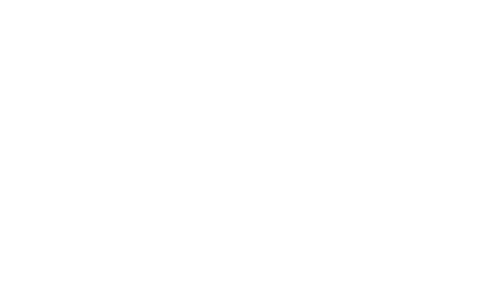
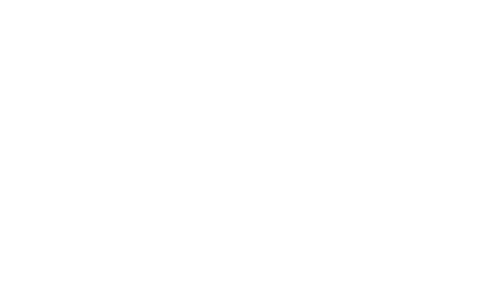
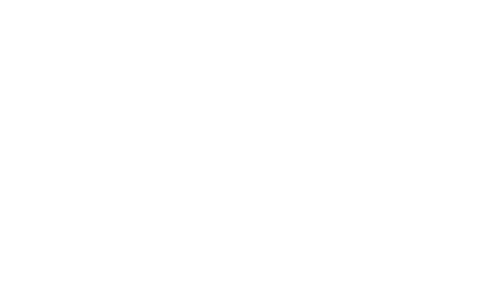
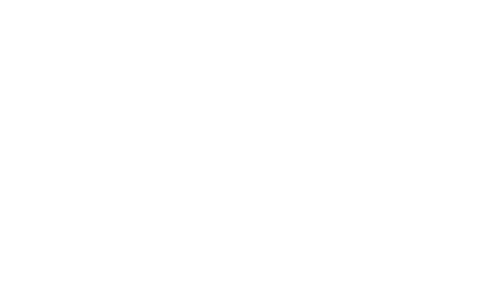
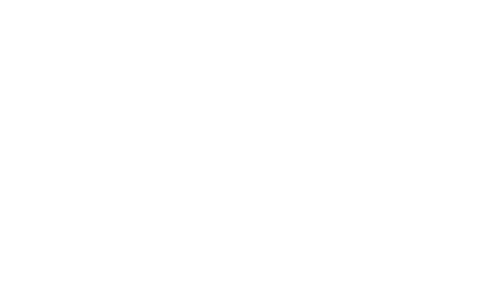
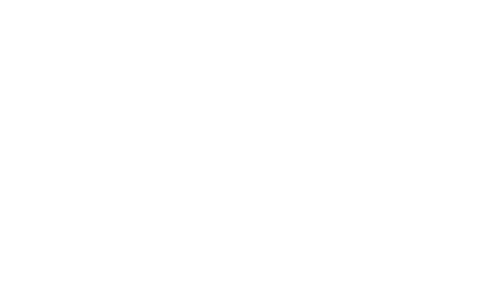
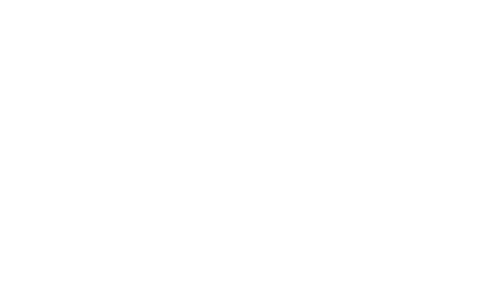

In [4]:
content = scrape_cineman(cities=["Bern", "Zürich"])
content

### Extracting Movie Showtimes

In [5]:
def format_cineman_content(content):
    """
    This function takes in content scraped from cineman.ch with BeautifulSoup and creates a dataframe from it.
    
    Required arguments:
    - content: html contents scraped from cineman.ch
    
    Returns:
    - movie_program_df: pandas dataframe containing the scraped data
    """
    movies = content.findAll("div", {"class": "col-xs-12 col-sm-9"})
    
    # Now create the data frame
    # Initialize the lists to store the details for each movie screening
    movies_list = []
    genres_list = []
    cinemas_list = []
    places_list = []
    age_limits = []
    all_showtimes_lists = []
    all_languages_lists = []

    for movie in movies:
        # Movie title
        title = movie.find("h4").get_text()
        movies_list.append(title)

        # Movie genre
        genre = movie.find("p").get_text()
        genres_list.append(genre)

        # Cinemas and place
        cinemas = movie.findAll("h5")
        cinema_names = []
        places = []

        for cinema in cinemas:
            cinema_name = cinema.find("em").get_text()
            cinema_names.append(cinema_name)
            place = cinema.findAll("a")[1].get_text()
            places.append(place)

        cinemas_list.append(cinema_names)
        places_list.append(places)

        # Age limit
        age_links = movie.findAll("a", {"class": "link"})
        age_limit = age_links[-1].get_text()
        if age_limit == "Reservation":
            age_limit = age_links[-2].get_text()
        if age_limit.find("Y.") == -1:
            age_limits.append("unknown")
        else:
            age_limits.append(age_limit)

        # Showtimes and languages
        showtimes_list_div = movie.find("div", {"class": "showtimes-list"})
        showtimes_string = showtimes_list_div.prettify().split("h5")
        showtimes_list = []
        languages_list = []

        for string in showtimes_string:
            strings = re.sub('<[^<]+?>\n', '', string).split(" ")
            showtimes = []
            languages = []

            for s in strings:
                s = s.strip("<></–)")
                s = re.sub("\t", "", s)
                s = s.strip()

                if is_time_format(s):
                    showtimes.append(s)

                elif (s.find("/") != -1 and s.find("Y.") == -1) or s in ["G", "F", "O", "I", "E"]:
                    languages.append(s)

            if showtimes:
                showtimes_list.append(showtimes)
            if languages:
                languages_list.append(languages)

        if showtimes_list:
            all_showtimes_lists.append(showtimes_list)
        if languages_list:
            all_languages_lists.append(languages_list)

    # Initializing the dictionary to store the lists
    all_info_dict = dict()

    all_info_dict["movie"] = movies_list
    all_info_dict["genre"] = genres_list
    all_info_dict["age_limit"] = age_limits
    all_info_dict["language"] = all_languages_lists
    all_info_dict["showtime"] = all_showtimes_lists
    all_info_dict["date"] = date.today()
    all_info_dict["cinema"] = cinemas_list
    all_info_dict["place"] = places_list

    movie_program_df = pd.DataFrame(all_info_dict).explode(["cinema", "showtime", "place", "language"]).explode(
        ["showtime", "language"]).reset_index(drop=True)
    movie_program_df["cinema_place"] = [f'{c} {p}' for c, p in zip(movie_program_df["cinema"], movie_program_df["place"])]

    return movie_program_df


In [6]:
movie_program_df = format_cineman_content(content)
movie_program_df.head()

,movie,genre,age_limit,language,showtime,date,cinema,place,cinema_place
0,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:20,2021-10-10,Houdini,Zürich,Houdini Zürich
1,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:30,2021-10-10,Houdini,Zürich,Houdini Zürich
2,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:20,2021-10-10,Kosmos,Zürich,Kosmos Zürich
3,No Time to Die,"Action, Adventure, Thriller",14Y.,G,20:20,2021-10-10,Arena Cinemas,Zürich,Arena Cinemas Zürich
4,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:30,2021-10-10,Arena Cinemas,Zürich,Arena Cinemas Zürich


## Location Data - Google API

In [7]:
def get_theatre_coordinates(showtimes_df, google_credentials_path):
    """
    This function takes in a dataframe with the names of movie theatres and the path to the credentials for the google api.
    It then requests the coordinates for the movie theatres via the api and stores them in a dataframe.
    
    Required arguments:
    - showtimes_df: pandas dataframe containing a column with movie theatre names and places
    - google_credentials_path: string, gives the path to the file with the google api credentials
    
    Returns:
    - showtimes_df: pandas dataframe that was given as an input, but with the coordinates added in for each theatre
    """
    # Getting location data from the Google API
    key_json = json.load(open(google_credentials_path))
    gmaps_key = key_json["key"]

    url = "https://maps.googleapis.com/maps/api/place/textsearch/json?"
    api_key = gmaps_key

    latitudes_list = []
    longitudes_list = []

    for theatre in showtimes_df["cinema_place"].unique():
        # text string on which to search
        query = theatre

        # get method of requests module, return response object
        req = requests.get(url + "query=" + query + "&key=" + api_key)

        # json method of response object: json format data -> python format data
        places_json = req.json()

        # now result contains list of nested dictionaries
        my_result = places_json["results"]

        # take a look at the first element
        latitude = my_result[0]["geometry"]["location"]["lat"]
        latitudes_list.append(latitude)

        longitude = my_result[0]["geometry"]["location"]["lng"]
        longitudes_list.append(longitude)

    theatre_location_dict = dict()
    theatre_location_dict["cinema_place"] = showtimes_df["cinema_place"].unique()
    theatre_location_dict["latitude"] = latitudes_list
    theatre_location_dict["longitude"] = longitudes_list

    theatre_locations_df = pd.DataFrame(theatre_location_dict)
    showtimes_df = pd.merge(showtimes_df, theatre_locations_df, how="left")
    
    return showtimes_df

In [8]:
google_credentials_path = "../../../Propulsion/DS_course_082021/google_api/credentials.json"
showtimes_df = get_theatre_coordinates(movie_program_df, google_credentials_path)
showtimes_df.head()

,movie,genre,age_limit,language,showtime,date,cinema,place,cinema_place,latitude,longitude
0,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:20,2021-10-10,Houdini,Zürich,Houdini Zürich,47.374607,8.520307
1,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:30,2021-10-10,Houdini,Zürich,Houdini Zürich,47.374607,8.520307
2,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:20,2021-10-10,Kosmos,Zürich,Kosmos Zürich,47.379981,8.529081
3,No Time to Die,"Action, Adventure, Thriller",14Y.,G,20:20,2021-10-10,Arena Cinemas,Zürich,Arena Cinemas Zürich,47.358460,8.522921
4,No Time to Die,"Action, Adventure, Thriller",14Y.,E/gf,20:30,2021-10-10,Arena Cinemas,Zürich,Arena Cinemas Zürich,47.358460,8.522921


In [9]:
#showtimes_df.to_csv(f"data/{date.today()}_showtimes_bern.csv")